In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from lcfunctions import download_lasair_lc, display_lightcurve
from lcfunctions import lasair_clean, load_lasair_lc
# ignore warnings
import warnings
from metadatafeatures import distance, absmag
warnings.filterwarnings('ignore')

### Generate dataset

In [15]:
label_scheme = 'labels_1'

pd.options.display.max_columns = None

dataset = pd.read_csv(f'../processed_data/dataset_allfeatures_inc_labels.csv', low_memory=False)
dataset = dataset[dataset[label_scheme].notna()].reset_index(drop=True)
print(dataset[label_scheme].value_counts())
print(dataset.shape)
pd.options.display.max_rows= None


dwarf_nova_SU_UMa    546
dwarf_nova_Z_Cam     174
nova_like            123
nova_like_VY_Scl     120
dwarf_nova_U_Gem     116
polar                114
dwarf_nova_WZ_Sge     58
int_polar             49
AMCVn                 46
nova                  31
dwarf_nova_ER_UMa     26
nova_remnant          21
nova_decline          15
Name: labels_1, dtype: int64
(1439, 270)


### Dataset for plots

In [16]:
# Add absolute g magnitude column
datasetforplot = dataset.copy()
datasetforplot['absmag_ztf_g'] = absmag(datasetforplot['median_g'], datasetforplot['distance'])
# Add absolute r magnitude column
datasetforplot['absmag_ztf_r'] = absmag(datasetforplot['median_r'], datasetforplot['distance'])

datasetforplot['periodLStest_g'] = 1/datasetforplot['freq_pwr_max_g']
# datasetforplot[['periodLStest_g','PeriodLS_g','labels_2']]
print(datasetforplot.columns.tolist())

['oid_ztf', 'oid_aavso', 'type_aavso', 'Eclipsing', 'CV_Types', 'CV_subtypes', 'CV_subsubtypes', 'eclipse_clear', 'manual_label', 'Clarity', 'labels_1', 'labels_2', 'labels_3', 'labels_4', 'Amplitude_g', 'AndersonDarling_g', 'Autocor_length_g', 'Beyond1Std_g', 'CAR_mean_g', 'CAR_sigma_g', 'CAR_tau_g', 'Con_g', 'Eta_e_g', 'FluxPercentileRatioMid20_g', 'FluxPercentileRatioMid35_g', 'FluxPercentileRatioMid50_g', 'FluxPercentileRatioMid65_g', 'FluxPercentileRatioMid80_g', 'Freq1_harmonics_amplitude_0_g', 'Freq1_harmonics_amplitude_1_g', 'Freq1_harmonics_amplitude_2_g', 'Freq1_harmonics_amplitude_3_g', 'Freq1_harmonics_rel_phase_1_g', 'Freq1_harmonics_rel_phase_2_g', 'Freq1_harmonics_rel_phase_3_g', 'Freq2_harmonics_amplitude_0_g', 'Freq2_harmonics_amplitude_1_g', 'Freq2_harmonics_amplitude_2_g', 'Freq2_harmonics_amplitude_3_g', 'Freq2_harmonics_rel_phase_1_g', 'Freq2_harmonics_rel_phase_2_g', 'Freq2_harmonics_rel_phase_3_g', 'Freq3_harmonics_amplitude_0_g', 'Freq3_harmonics_amplitude_1_g',

### Strip, box and KDE plots

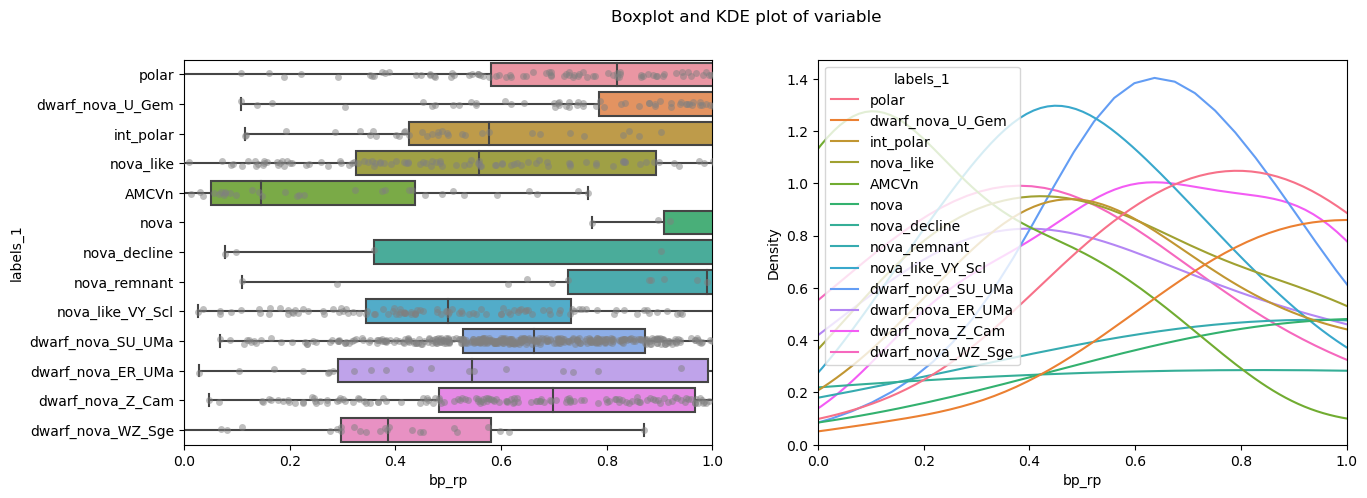

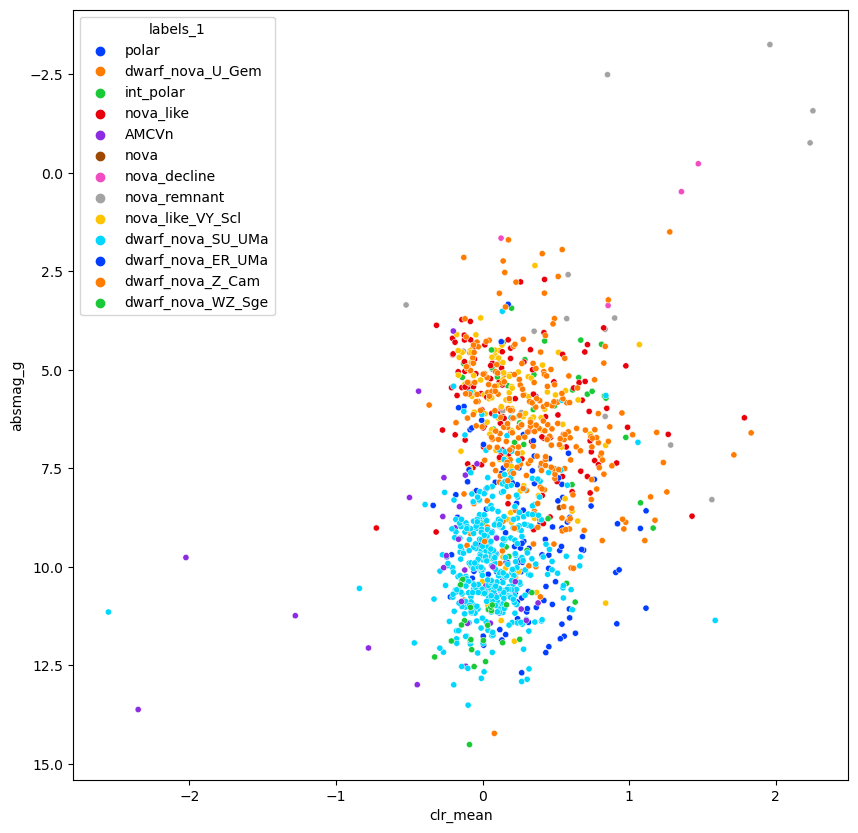

In [17]:
dataframe = datasetforplot # dataframe to plot
name = 'bp_rp'
limits = (0,1)
labels = 'labels_1'
plt.rcdefaults()


fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Boxplot and KDE plot of variable')

sns.boxplot(ax=axes[0], data=dataframe, x=name, y=labels)
sns.stripplot(ax=axes[0], data=dataframe, x=name, y=labels, color='grey', alpha=0.5)
axes[0].set(xlim=limits)
sns.kdeplot(ax=axes[1], x=name, data=dataframe, hue=labels, common_norm=False)
axes[1].set(xlim=limits)
plt.show()


# dataframe[name].hist(bins=75, grid=False,figsize=(5,3))
fig2 = plt.figure(figsize=(10,10))
sns.scatterplot(data=dataframe, x='clr_mean', y='absmag_g', hue=labels, alpha=1,s=20, palette='bright')
#invert y axis
plt.gca().invert_yaxis()
plt.savefig(f'../figures/cmd_gminusr.pdf', bbox_inches='tight', format='pdf')
plt.show()



### Per class scatter plots

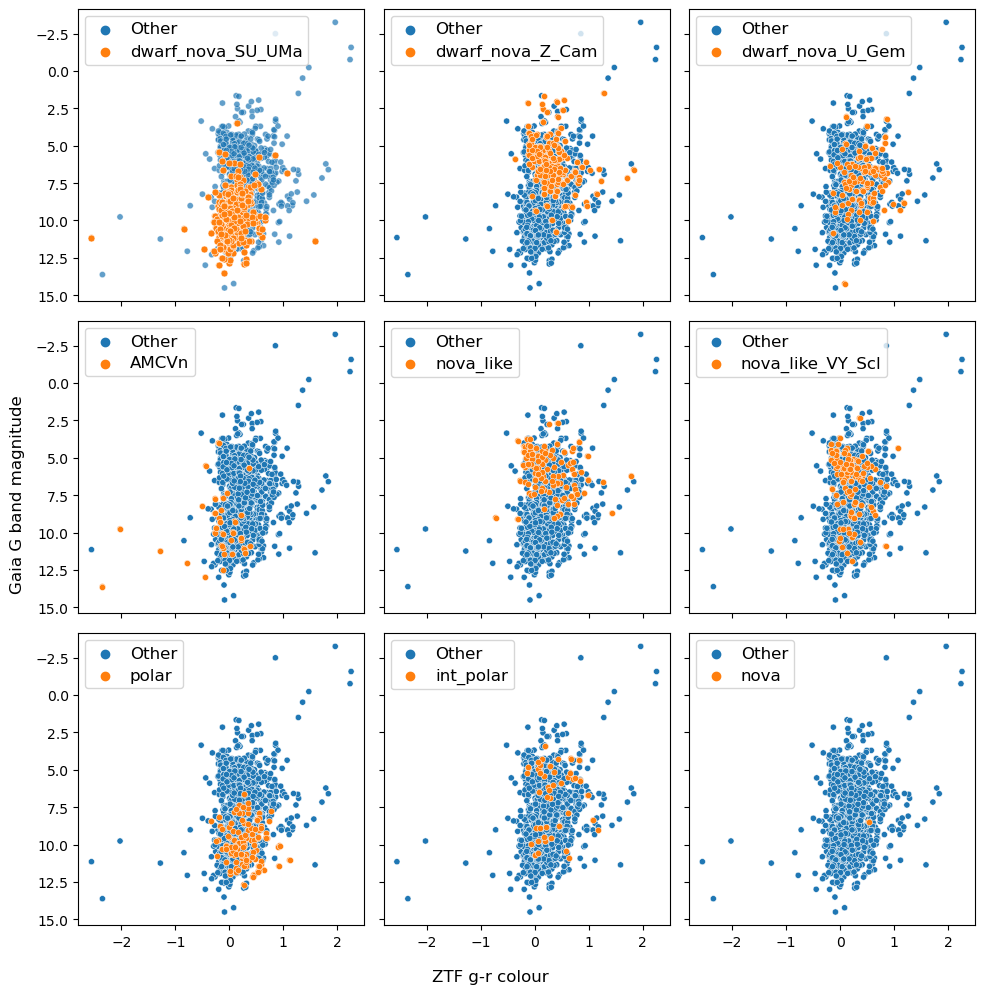

In [18]:
# Construct a figure of clr_mean vs absmag_g where the hue is for AM CVns stars and the remaining stars
# are plotted in grey. The figure is saved to a pdf file.
dataframe_ovr = datasetforplot[['clr_mean','bp_rp','absmag_g', 'absmag_ztf_g', 'absmag_ztf_r', 'absmag_bp', 'absmag_rp', label_scheme]]
for cvclass in np.unique(dataframe_ovr[label_scheme]).tolist():
    dataframe_ovr.loc[(dataframe_ovr.labels_1.isin([cvclass])), cvclass] = cvclass
    dataframe_ovr.loc[(dataframe_ovr.labels_1.isin([cvclass]) == False), cvclass] = 'Other'


x = 'clr_mean'
y= 'absmag_g'
f1 = 12
f2 = 12
f3 = 10

fig3, ax = plt.subplots(nrows=3,ncols=3,figsize=(10,10), layout='tight', sharex=True, sharey=True)
fig3.supxlabel('ZTF g-r colour', fontsize=f1)
fig3.supylabel('Gaia G band magnitude', fontsize=f1)
sns.scatterplot(ax=ax[0,0],data=dataframe_ovr, x=x, y=y, hue='dwarf_nova_SU_UMa', alpha=0.7,s=20, legend='brief')
sns.scatterplot(ax=ax[0,0],data=dataframe_ovr[dataframe_ovr['dwarf_nova_SU_UMa']=='dwarf_nova_SU_UMa'], x=x, y=y, alpha=1,s=25)
ax[0,0].invert_yaxis()
ax[0,0].set(ylabel=None)
plt.setp(ax[0,0].get_legend().get_texts(), fontsize=f2) # for legend text
sns.scatterplot(ax=ax[0,1],data=dataframe_ovr, x=x, y=y, hue='dwarf_nova_Z_Cam', alpha=1,s=20,legend='brief')
sns.scatterplot(ax=ax[0,1],data=dataframe_ovr[dataframe_ovr['dwarf_nova_Z_Cam']=='dwarf_nova_Z_Cam'], x=x, y=y, alpha=1,s=20)
ax[0,1].invert_yaxis()
plt.setp(ax[0,1].get_legend().get_texts(), fontsize=f2) # for legend text
sns.scatterplot(ax=ax[0,2],data=dataframe_ovr, x=x, y=y, hue='dwarf_nova_U_Gem', alpha=1,s=20,legend='brief')
sns.scatterplot(ax=ax[0,2],data=dataframe_ovr[dataframe_ovr['dwarf_nova_U_Gem']=='dwarf_nova_U_Gem'], x=x, y=y, alpha=1,s=20)
ax[0,2].invert_yaxis()
plt.setp(ax[0,2].get_legend().get_texts(), fontsize=f2) # for legend text
sns.scatterplot(ax=ax[1,0],data=dataframe_ovr, x=x, y=y, hue='AMCVn', alpha=1,s=20,legend='brief')
sns.scatterplot(ax=ax[1,0],data=dataframe_ovr[dataframe_ovr['AMCVn']=='AMCVn'], x=x, y=y, alpha=1,s=20,legend='brief')
ax[1,0].invert_yaxis()
ax[1,0].set(ylabel=None)
plt.setp(ax[1,0].get_legend().get_texts(), fontsize=f2) # for legend text
sns.scatterplot(ax=ax[1,1],data=dataframe_ovr, x=x, y=y, hue='nova_like', alpha=1,s=20,legend='brief')
sns.scatterplot(ax=ax[1,1],data=dataframe_ovr[dataframe_ovr['nova_like']=='nova_like'], x=x, y=y, alpha=1,s=20,legend='brief')
ax[1,1].invert_yaxis()
plt.setp(ax[1,1].get_legend().get_texts(), fontsize=f2) # for legend text
sns.scatterplot(ax=ax[1,2],data=dataframe_ovr, x=x, y=y, hue='nova_like_VY_Scl', alpha=1,s=20,legend='brief')
sns.scatterplot(ax=ax[1,2],data=dataframe_ovr[dataframe_ovr['nova_like_VY_Scl']=='nova_like_VY_Scl'], x=x, y=y, alpha=1,s=20,legend='brief')
ax[1,2].invert_yaxis()
plt.setp(ax[1,2].get_legend().get_texts(), fontsize=f2) # for legend text
sns.scatterplot(ax=ax[2,0],data=dataframe_ovr, x=x, y=y, hue='polar', hue_order=('Other','polar'),alpha=1,s=20,legend='brief')
sns.scatterplot(ax=ax[2,0],data=dataframe_ovr[dataframe_ovr['polar']=='polar'], x=x, y=y,alpha=1,s=20,legend='brief')
ax[2,0].invert_yaxis()
ax[2,0].set(xlabel=None)
ax[2,0].set(ylabel=None)
plt.setp(ax[2,0].get_legend().get_texts(), fontsize=f2) # for legend text
sns.scatterplot(ax=ax[2,1],data=dataframe_ovr, x=x, y=y, hue='int_polar', alpha=1,s=20,legend='brief')
sns.scatterplot(ax=ax[2,1],data=dataframe_ovr[dataframe_ovr['int_polar']=='int_polar'], x=x, y=y, alpha=1,s=20,legend='brief')
ax[2,1].invert_yaxis()
ax[2,1].set(xlabel=None)
plt.setp(ax[2,1].get_legend().get_texts(), fontsize=f2) # for legend text
sns.scatterplot(ax=ax[2,2],data=dataframe_ovr, x=x, y=y, hue='nova', alpha=1,s=20,legend='brief')
sns.scatterplot(ax=ax[2,2],data=dataframe_ovr[dataframe_ovr['nova']=='nova'], x=x, y=y, alpha=1,s=20,legend='brief')
ax[2,2].invert_yaxis()
ax[2,2].set(xlabel=None)

ax[2,0].xaxis.set_tick_params(labelsize=f3)
ax[2,1].xaxis.set_tick_params(labelsize=f3)
ax[2,2].xaxis.set_tick_params(labelsize=f3)
ax[0,0].yaxis.set_tick_params(labelsize=f3)
ax[1,0].yaxis.set_tick_params(labelsize=f3)
ax[2,0].yaxis.set_tick_params(labelsize=f3)

plt.setp(ax[2,2].get_legend().get_texts(), fontsize=f2) # for legend text
plt.savefig(f'../figures/cmd_Gvsgminusr.pdf', bbox_inches='tight', format='pdf')

plt.show()

# sns.FacetGrid


### Example light curves of different CV classes

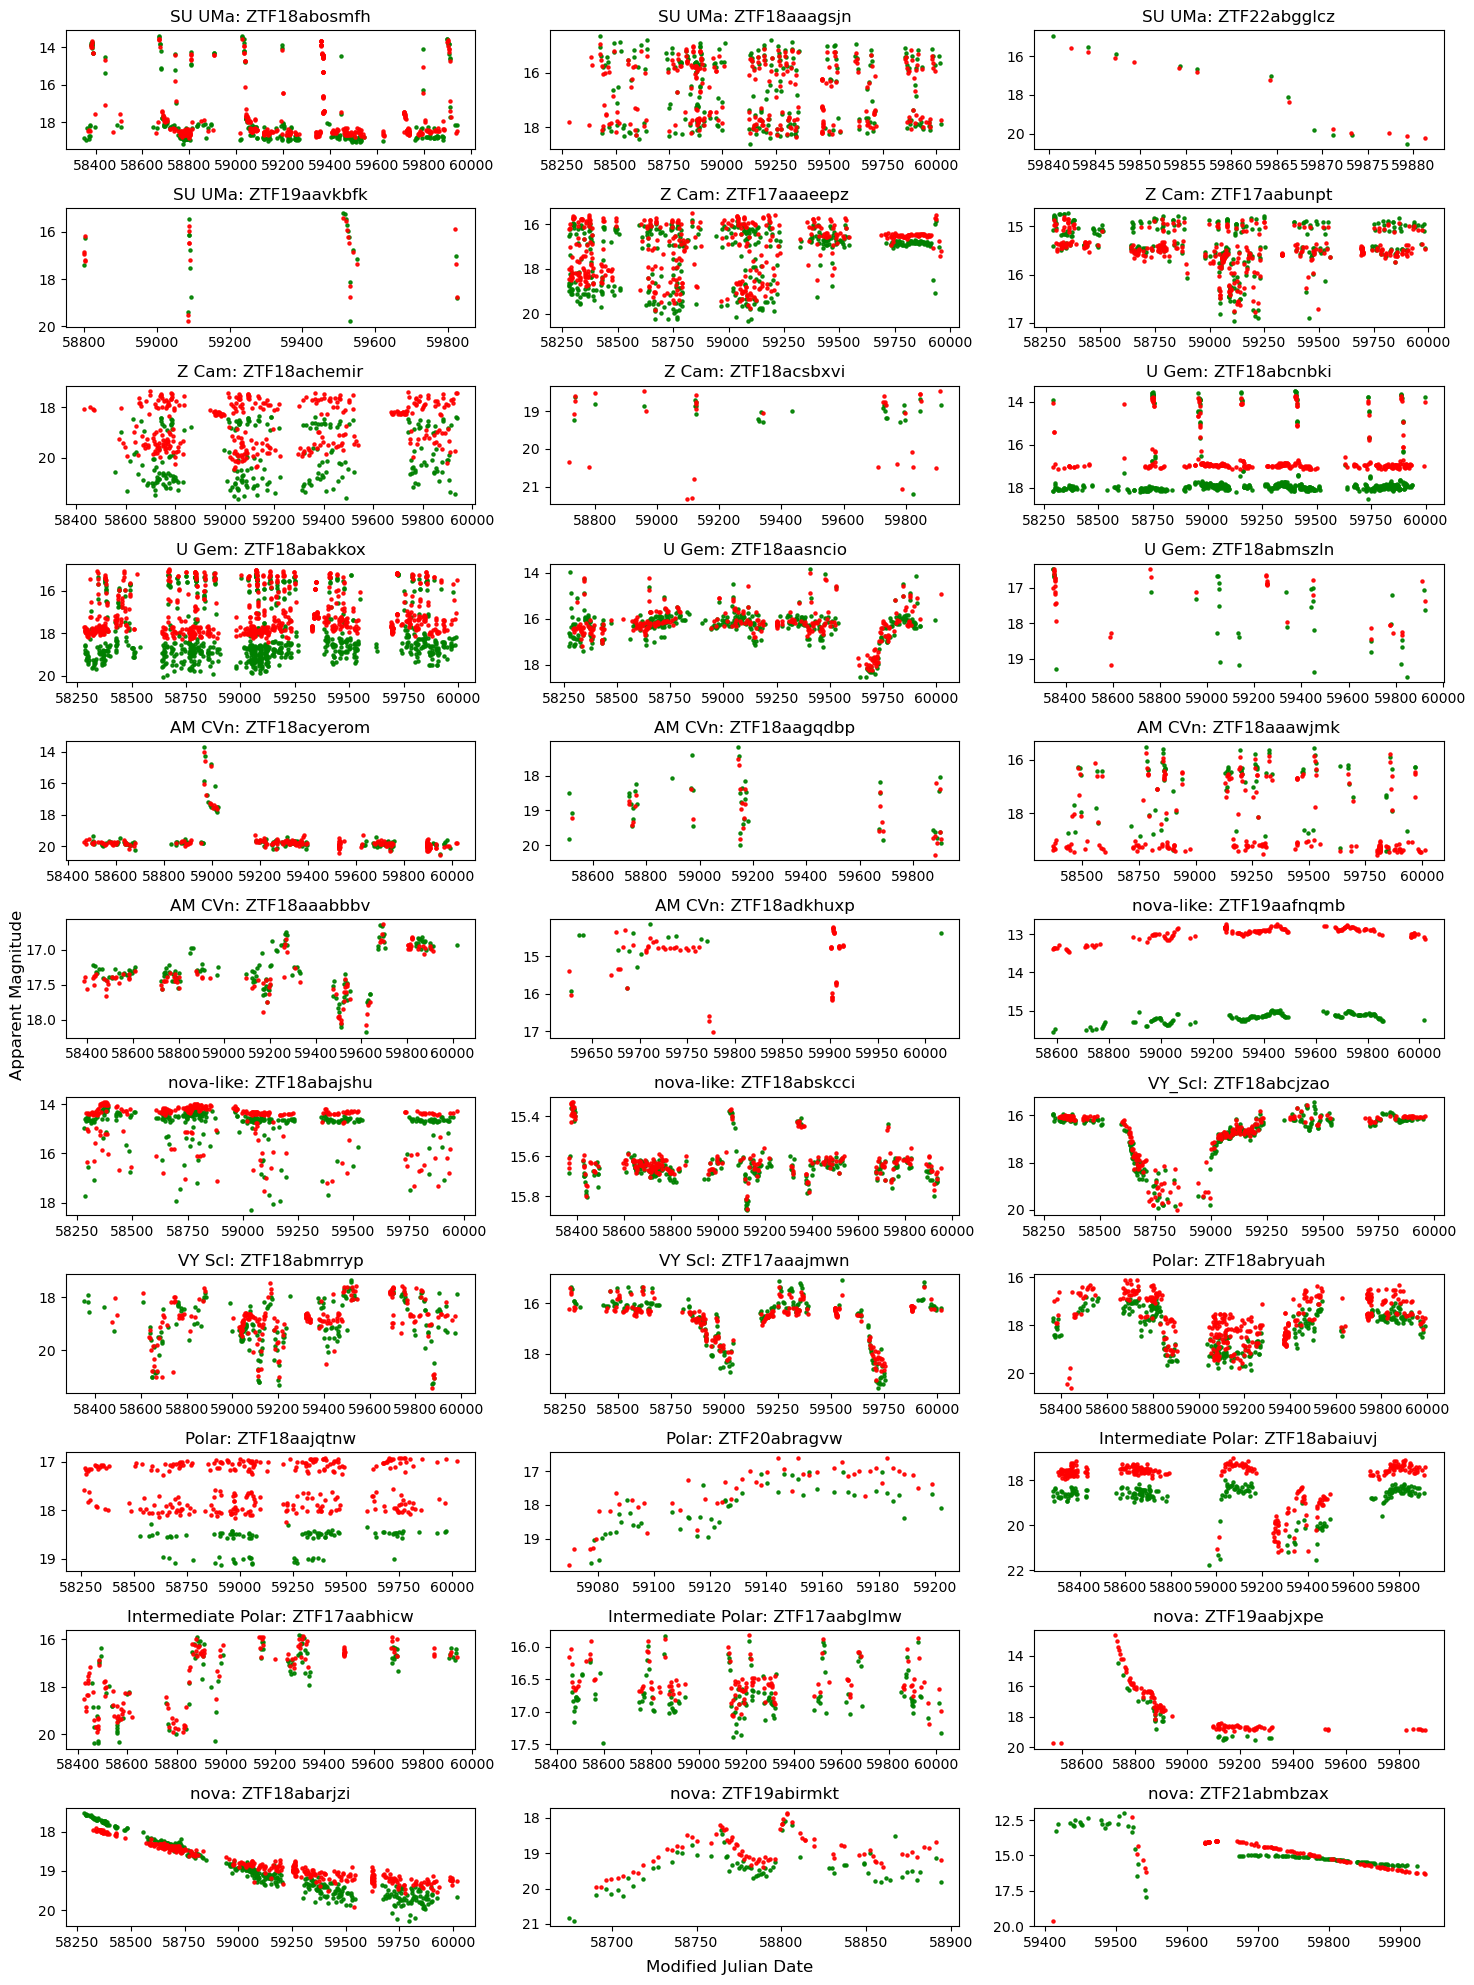

In [19]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter


fig, ax = plt.subplots(nrows=11,ncols=3,figsize=(15, 20), layout='tight')
fig.supxlabel('Modified Julian Date')
fig.supylabel('Apparent Magnitude')
s=5
fontsize = 10
alpha = 0.9

sources = np.array(['ZTF18abosmfh', 'ZTF18aaagsjn', 'ZTF22abgglcz',
                    'ZTF19aavkbfk', 'ZTF17aaaeepz', 'ZTF17aabunpt',
                    'ZTF18achemir', 'ZTF18acsbxvi', 'ZTF18abcnbki',
                    'ZTF18abakkox', 'ZTF18aasncio', 'ZTF18abmszln',
                    'ZTF18acyerom', 'ZTF18aagqdbp', 'ZTF18aaawjmk',
                    'ZTF18aaabbbv', 'ZTF18adkhuxp', 'ZTF19aafnqmb',
                    'ZTF18abajshu', 'ZTF18abskcci', 'ZTF18abcjzao',
                    'ZTF18abmrryp', 'ZTF17aaajmwn', 'ZTF18abryuah',
                    'ZTF18aajqtnw', 'ZTF20abragvw', 'ZTF18abaiuvj',
                    'ZTF17aabhicw', 'ZTF17aabglmw', 'ZTF19aabjxpe',
                    'ZTF18abarjzi', 'ZTF19abirmkt', 'ZTF21abmbzax'
                    ])

source_class = np.array(['SU UMa', 'SU UMa', 'SU UMa',
                         'SU UMa', 'Z Cam', 'Z Cam',
                         'Z Cam', 'Z Cam', 'U Gem',
                         'U Gem','U Gem','U Gem',
                         'AM CVn','AM CVn','AM CVn',
                         'AM CVn','AM CVn','nova-like',
                         'nova-like','nova-like','VY_Scl',
                         'VY Scl','VY Scl','Polar',
                         'Polar','Polar','Intermediate Polar',
                         'Intermediate Polar','Intermediate Polar','nova',
                         'nova','nova','nova'
                         ])

sources = sources.reshape(11,3)
source_class = source_class.reshape(11,3)


for row in range(11):
    for col in range(3):
        object = sources[row,col]
        try:
            lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_2023_03_25')
        except:
            # Create a folder within path for LCs if one does not exist
            if not os.path.exists(f'../lightcurves_dataset/lasair_non_dataset/cache'):
                os.makedirs(f'../lightcurves_dataset/lasair_non_dataset/cache')
            download_lasair_lc([object], folderpath=f'../lightcurves_dataset/lasair_non_dataset', cache=f'../lightcurves_dataset/lasair_non_dataset/cache')
            lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_non_dataset')
        
        lc_lasair_appmag = lasair_clean(lc_lasair, limit=25, magerrlim=1)
        
        lc_g = lc_lasair_appmag[lc_lasair_appmag['fid'] == 1]
        lc_r = lc_lasair_appmag[lc_lasair_appmag['fid'] == 2]
        ax[row,col].set_title(f'{source_class[row,col]}: {sources[row,col]}')
        ax[row,col].scatter(lc_g['jd']-2400000.5, lc_g['dc_mag'], c='green', s=s, label='g', alpha=alpha)
        ax[row,col].scatter(lc_r['jd']-2400000.5, lc_r['dc_mag'], c='red', s=s, label='r', alpha=alpha)
        ax[row,col].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax[row,col].invert_yaxis()


fig.savefig(f'../figures/class_lightcurves.pdf', bbox_inches='tight', format='pdf')

plt.show()


0 ZTF18aczycws
0 ZTF21acbqaqa
0 ZTF18acqllgh
0 ZTF23aaknjqb
0 ZTF18abceint
0 ZTF18aapaldh


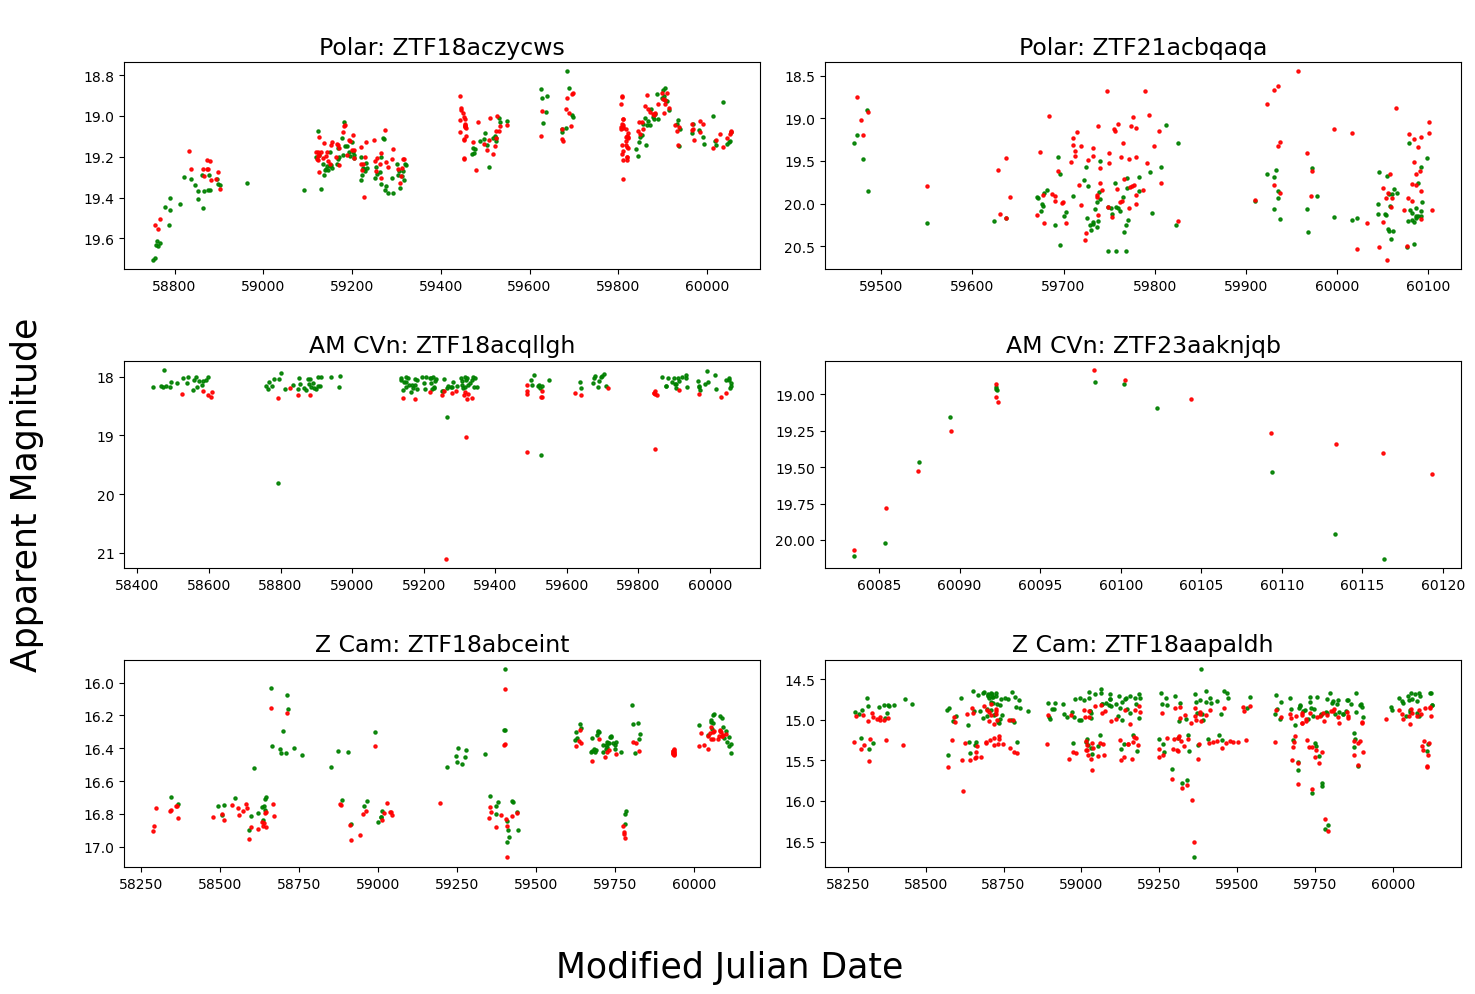

In [20]:
from matplotlib.ticker import FormatStrFormatter

r = 3
c = 2


fig2, ax2 = plt.subplots(nrows=r,ncols=c,figsize=(15, 10), layout='tight')
fig2.supxlabel('\nModified Julian Date', fontsize=25)
fig2.supylabel('Apparent Magnitude\n', fontsize=25)

s=5
fontsize = 17
alpha = 0.9


sources = np.array(['ZTF18aczycws',
                    'ZTF21acbqaqa',
                    'ZTF18acqllgh',
                    'ZTF23aaknjqb',
                    'ZTF18abceint',
                    'ZTF18aapaldh'
                    ])

source_class = np.array(['Polar',
                         'Polar',
                         'AM CVn',
                         'AM CVn',
                         'Z Cam',
                         'Z Cam'
                         ])

sources = sources.reshape(r,c)
source_class = source_class.reshape(r,c)


for row in range(r):
    for col in range(c):
        object = sources[row,col]
        try:
            lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_2023_03_25')
        except:
            # Create a folder within path for LCs if one does not exist
            if not os.path.exists(f'../lightcurves_dataset/lasair_non_dataset/cache'):
                os.makedirs(f'../lightcurves_dataset/lasair_non_dataset/cache')
            download_lasair_lc([object], folderpath=f'../lightcurves_dataset/lasair_non_dataset', cache=f'../lightcurves_dataset/lasair_non_dataset/cache')
            lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_non_dataset')
        
        lc_lasair_appmag = lasair_clean(lc_lasair, limit=25, magerrlim=1)
        
        lc_g = lc_lasair_appmag[lc_lasair_appmag['fid'] == 1]
        lc_r = lc_lasair_appmag[lc_lasair_appmag['fid'] == 2]
        ax2[row,col].set_title(f'\n{source_class[row,col]}: {sources[row,col]}', fontsize=fontsize)
        ax2[row,col].scatter(lc_g['jd']-2400000.5, lc_g['dc_mag'], c='green', s=s, label='g', alpha=alpha)
        ax2[row,col].scatter(lc_r['jd']-2400000.5, lc_r['dc_mag'], c='red', s=s, label='r', alpha=alpha)
        ax2[row,col].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax2[row,col].invert_yaxis()

fig2.savefig(f'../figures/class_lightcurves2.pdf', bbox_inches='tight', format='pdf')





ZTF18aczycws
0 ZTF18aczycws
ZTF21acbqaqa
0 ZTF21acbqaqa
ZTF18acqllgh
0 ZTF18acqllgh
ZTF23aaknjqb
0 ZTF23aaknjqb
ZTF18abceint
0 ZTF18abceint
ZTF18aapaldh
0 ZTF18aapaldh


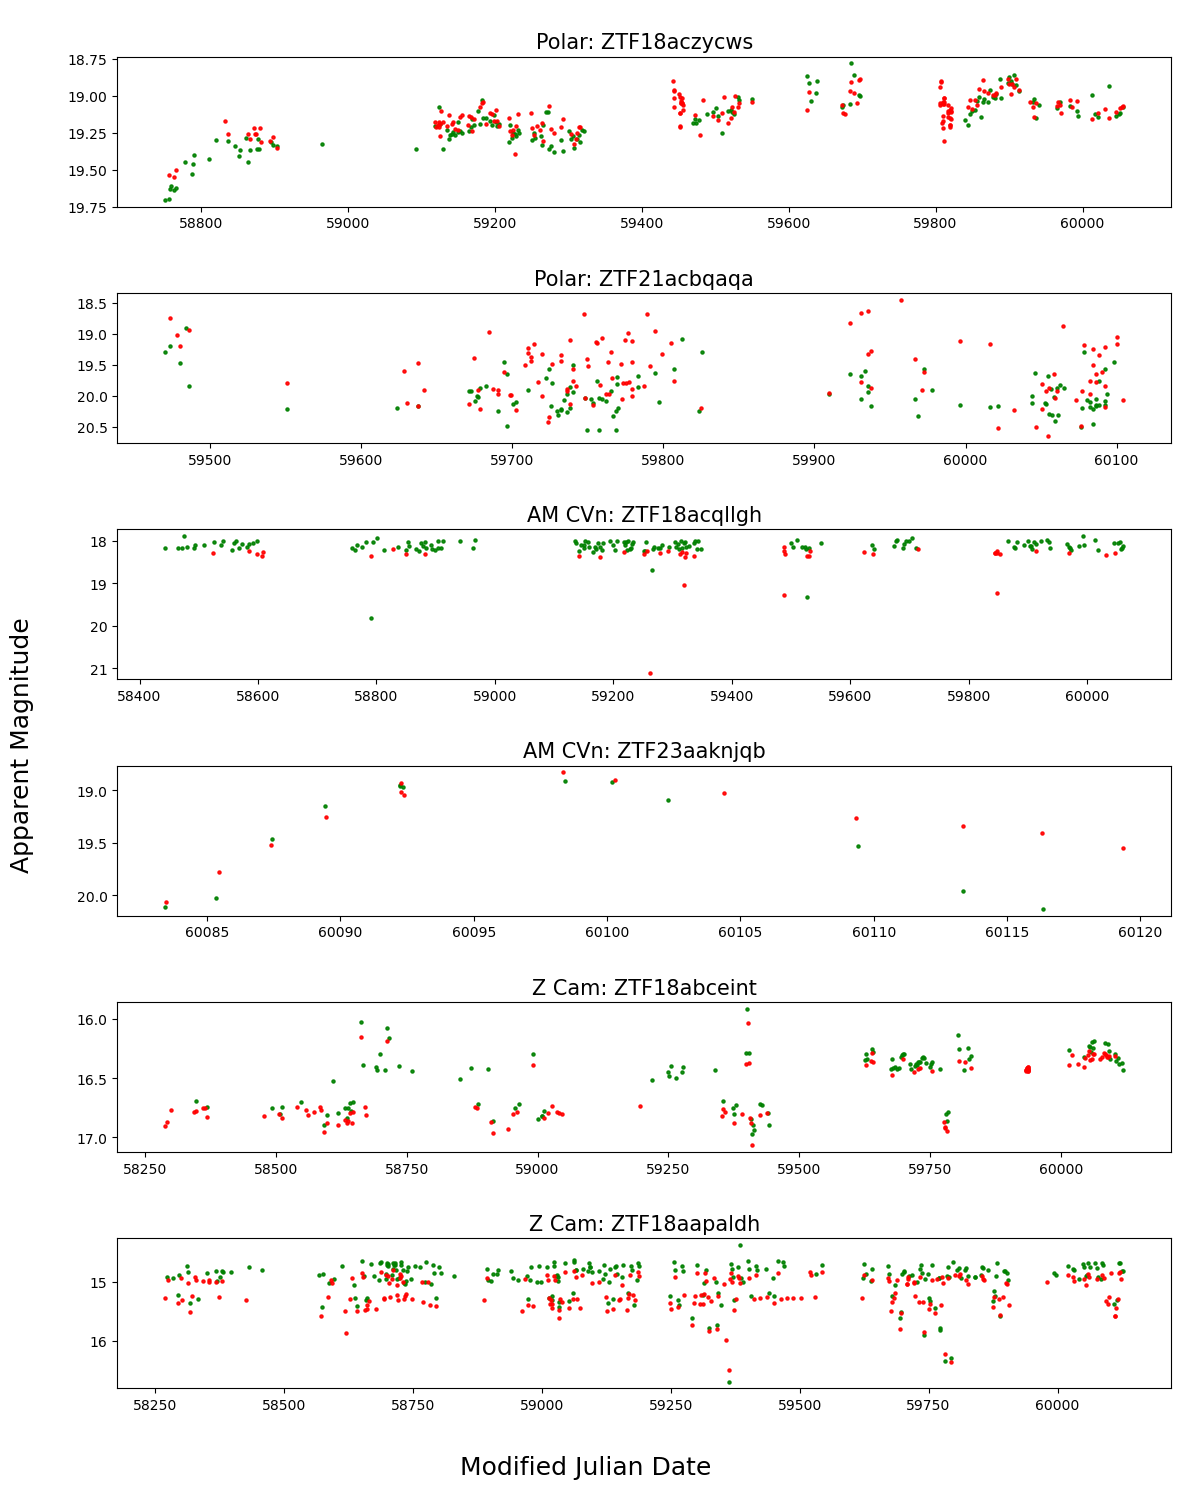

In [21]:
from matplotlib.ticker import FormatStrFormatter

r = 6
c = 1


fig2, ax2 = plt.subplots(nrows=r,ncols=c,figsize=(12, 15), layout='tight')
fig2.supxlabel('\nModified Julian Date', fontsize=18)
fig2.supylabel('Apparent Magnitude\n', fontsize=18)

s=5
fontsize = 15
alpha = 0.9


sources = np.array(['ZTF18aczycws',
                    'ZTF21acbqaqa',
                    'ZTF18acqllgh',
                    'ZTF23aaknjqb',
                    'ZTF18abceint',
                    'ZTF18aapaldh'
                    ])

                    

source_class = np.array(['Polar',
                         'Polar',
                         'AM CVn',
                         'AM CVn',
                         'Z Cam',
                         'Z Cam'
                         ])
                         

sources = sources.reshape(r,c)
source_class = source_class.reshape(r,c)


for row in range(r):
    for col in range(c):
        object = sources[row].item()
        print(object)
        try:
            lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_2023_03_25')
        except:
            # Create a folder within path for LCs if one does not exist
            if not os.path.exists(f'../lightcurves_dataset/lasair_non_dataset/cache'):
                os.makedirs(f'../lightcurves_dataset/lasair_non_dataset/cache')
            download_lasair_lc([object], folderpath=f'../lightcurves_dataset/lasair_non_dataset', cache=f'../lightcurves_dataset/lasair_non_dataset/cache')
            lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_non_dataset')
        
        lc_lasair_appmag = lasair_clean(lc_lasair, limit=25, magerrlim=1)
        
        lc_g = lc_lasair_appmag[lc_lasair_appmag['fid'] == 1]
        lc_r = lc_lasair_appmag[lc_lasair_appmag['fid'] == 2]
        ax2[row].set_title(f'\n{source_class[row].item()}: {sources[row].item()}', fontsize=fontsize)
        ax2[row].scatter(lc_g['jd']-2400000.5, lc_g['dc_mag'], c='green', s=s, label='g', alpha=alpha)
        ax2[row].scatter(lc_r['jd']-2400000.5, lc_r['dc_mag'], c='red', s=s, label='r', alpha=alpha)
        ax2[row].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax2[row].invert_yaxis()

fig2.savefig(f'../figures/class_lightcurves2.pdf', bbox_inches='tight', format='pdf')

### Heatmap of model performance

In [22]:
# Construct dataframe where each row is a model variant and each column is a different performance metric.
# Each cell is the performance of the model variant on the metric.
# The dataframe is then saved as a csv file.
# We first construct a dictionary where each key is a model variant and each value is a dictionary of performance metrics.

# This function parses the classification report for each model to obtain the performance metrics for a particular row
# and places them  in a dictionary.
def resultstable(cr_row):

    classifierNm = {'gnb':'GNB','knn':'KNN','lda':'LDA','xgb':'XGB','rf':'RF','NN':'NN'}
    balancing = {'weights':'WTD','sampling':'SMPL'}
    frmethod = {'mi':'MUI', 'mi_':'MUI', 'sfs_':'FFS', 'anova':'ANO', 'anova_':'ANO', 'vif_':'VIF', '':'---'}

    results_dict = {}
    cr_row = cr_row #'macro avg' # AM CVn

    for clf in classifierNm.keys():
        for bal in balancing.keys():
            for fr in frmethod.keys():
                # print(clf, bal, fr)
                try:
                    if fr != '':
                        model_results = pd.read_csv(f'../results/cr/cr_{clf}_{bal}_{fr}.csv')
                        # print(model_results.loc[model_results['Unnamed: 0']==cr_row,:].iloc[:,1:4].values[0])
                        # print(model_results.loc[model_results['Unnamed: 0']=='accuracy',:].iloc[:,1].values[0])
                        # print(f'{classifierNm[clf]} + {balancing[bal]} + {frmethod[fr]}')
                        results_dict[f'{classifierNm[clf]} + {balancing[bal]} + {frmethod[fr]}'] = {
                                                                                                    'accuracy': model_results.loc[model_results['Unnamed: 0']=='accuracy',:].iloc[:,1].values[0],
                                                                                                    'precision': model_results.loc[model_results['Unnamed: 0']==cr_row,:].iloc[:,1].values[0],
                                                                                                    'recall': model_results.loc[model_results['Unnamed: 0']==cr_row,:].iloc[:,2].values[0],
                                                                                                    'f1 score': model_results.loc[model_results['Unnamed: 0']==cr_row,:].iloc[:,3].values[0]}

                    elif fr == '':
                        model_results = pd.read_csv(f'../results/cr/cr_{clf}_{bal}.csv')
                        # print(model_results.loc[model_results['Unnamed: 0']==cr_row,:].iloc[:,1:4].values[0])
                        # print(model_results.loc[model_results['Unnamed: 0']=='accuracy',:].iloc[:,1].values[0])
                        # print(f'{classifierNm[clf]} + {balancing[bal]} + {frmethod[fr]}')
                        results_dict[f'{classifierNm[clf]} + {balancing[bal]} + {frmethod[fr]}'] = {
                                                                                                    'accuracy': model_results.loc[model_results['Unnamed: 0']=='accuracy',:].iloc[:,1].values[0],
                                                                                                    'precision': model_results.loc[model_results['Unnamed: 0']==cr_row,:].iloc[:,1].values[0],
                                                                                                    'recall': model_results.loc[model_results['Unnamed: 0']==cr_row,:].iloc[:,2].values[0],
                                                                                                    'f1 score': model_results.loc[model_results['Unnamed: 0']==cr_row,:].iloc[:,3].values[0]}
                except:
                    continue
                    # print('No model found')
        
    results_df = pd.DataFrame(results_dict).T

    # order the rows alphabetically
    results_df = results_df.reindex(sorted(results_df.index))

    return results_df

# Get the macro average and per class performance metrics for each model variant.
results_df_all = resultstable('macro avg')
results_df_cv = resultstable('AMCVn')
results_df_su = resultstable('dwarf_nova_SU_UMa')
results_df_ug = resultstable('dwarf_nova_U_Gem')
results_df_zc = resultstable('dwarf_nova_Z_Cam')
results_df_vy = resultstable('nova_like_VY_Scl')
results_df_nl = resultstable('nova_like')
results_df_n = resultstable('nova')
results_df_p = resultstable('polar')
results_df_ip = resultstable('int_polar')

# Drop the accuracy column from each per class dataframe.
results_df_cv = results_df_cv.drop(columns=['accuracy'])
results_df_su = results_df_su.drop(columns=['accuracy'])
results_df_ug = results_df_ug.drop(columns=['accuracy'])
results_df_zc = results_df_zc.drop(columns=['accuracy'])
results_df_vy = results_df_vy.drop(columns=['accuracy'])
results_df_nl = results_df_nl.drop(columns=['accuracy'])
results_df_n = results_df_n.drop(columns=['accuracy'])
results_df_p = results_df_p.drop(columns=['accuracy'])
results_df_ip = results_df_ip.drop(columns=['accuracy'])

# Rename the columns to include the class name.
results_df_cv.rename(columns={'precision':'precision (AM CVn)', 'recall':'recall (AM CVn)', 'f1 score':'f1 score (AM CVn)'}, inplace=True)
results_df_su.rename(columns={'precision':'precision (SU UMa)', 'recall':'recall (SU UMa)', 'f1 score':'f1 score (SU UMa)'}, inplace=True)
results_df_ug.rename(columns={'precision':'precision (U Gem)', 'recall':'recall (U Gem)', 'f1 score':'f1 score (U Gem)'}, inplace=True)
results_df_zc.rename(columns={'precision':'precision (Z Cam)', 'recall':'recall (Z Cam)', 'f1 score':'f1 score (Z Cam)'}, inplace=True)
results_df_vy.rename(columns={'precision':'precision (VY Scl)', 'recall':'recall (VY Scl)', 'f1 score':'f1 score (VY Scl)'}, inplace=True)
results_df_nl.rename(columns={'precision':'precision (nova-like)', 'recall':'recall (nova-like)', 'f1 score':'f1 score (nova-like)'}, inplace=True)
results_df_n.rename(columns={'precision':'precision (nova)', 'recall':'recall (nova)', 'f1 score':'f1 score (nova)'}, inplace=True)
results_df_p.rename(columns={'precision':'precision (polar)', 'recall':'recall (polar)', 'f1 score':'f1 score (polar)'}, inplace=True)
results_df_ip.rename(columns={'precision':'precision (int polar)', 'recall':'recall (int polar)', 'f1 score':'f1 score (int polar)'}, inplace=True)

# Concatenate the dataframes.
results_df_comb = pd.concat([results_df_all, 
                             results_df_cv, 
                             results_df_su,
                             results_df_ug,
                             results_df_zc,
                             results_df_vy,
                             results_df_nl,
                             results_df_n,
                             results_df_p,
                             results_df_ip
                             ],
                             axis=1)

# Rename the indices as some models did not use class weighting.
results_df_comb.rename(index={'XGB + WTD + ---': 'XGB + --- + ---',
                              'GNB + WTD + ---':'GNB + --- + ---',
                              'GNB + WTD + ANO': 'GNB + --- + ANO',
                              'GNB + WTD + FFS':'GNB + --- + FFS',
                              'GNB + WTD + MUI':'GNB + --- + MUI',
                              'GNB + WTD + VIF':'GNB + --- + VIF',
                              'KNN + WTD + ---':'KNN + --- + ---',
                              'KNN + WTD + ANO':'KNN + --- + ANO',
                              'KNN + WTD + FFS':'KNN + --- + FFS',
                              'KNN + WTD + MUI':'KNN + --- + MUI',
                              'KNN + WTD + VIF':'KNN + --- + VIF',
                              'LDA + WTD + ---':'LDA + --- + ---',
                              'LDA + WTD + ANO':'LDA + --- + ANO',
                              'LDA + WTD + FFS':'LDA + --- + FFS',
                              'LDA + WTD + MUI':'LDA + --- + MUI',
                              'LDA + WTD + VIF':'LDA + --- + VIF',
                              },
                              inplace=True)

results_df_comb.head()


,accuracy,precision,recall,f1 score,precision (AM CVn),recall (AM CVn),f1 score (AM CVn),precision (SU UMa),recall (SU UMa),f1 score (SU UMa),precision (U Gem),recall (U Gem),f1 score (U Gem),precision (Z Cam),recall (Z Cam),f1 score (Z Cam),precision (VY Scl),recall (VY Scl),f1 score (VY Scl),precision (nova-like),recall (nova-like),f1 score (nova-like),precision (nova),recall (nova),f1 score (nova),precision (polar),recall (polar),f1 score (polar),precision (int polar),recall (int polar),f1 score (int polar)
GNB + SMPL + ---,0.48,0.43,0.48,0.43,0.07,0.29,0.12,0.83,0.41,0.55,0.36,0.46,0.41,0.57,0.54,0.55,0.62,0.58,0.60,0.45,0.65,0.53,0.21,0.57,0.30,0.60,0.62,0.61,0.14,0.20,0.17
GNB + SMPL + ANO,0.48,0.44,0.51,0.44,0.10,0.36,0.15,0.86,0.39,0.54,0.33,0.57,0.42,0.56,0.52,0.54,0.62,0.58,0.60,0.49,0.60,0.54,0.25,0.64,0.36,0.62,0.68,0.65,0.15,0.27,0.20
GNB + SMPL + FFS,0.56,0.45,0.53,0.47,0.30,0.43,0.35,0.88,0.59,0.71,0.41,0.57,0.48,0.52,0.46,0.49,0.50,0.61,0.55,0.50,0.42,0.46,0.28,0.79,0.41,0.49,0.71,0.58,0.15,0.20,0.17
GNB + SMPL + MUI,0.48,0.43,0.48,0.43,0.07,0.29,0.12,0.83,0.41,0.55,0.36,0.46,0.41,0.57,0.54,0.55,0.62,0.58,0.60,0.45,0.65,0.53,0.21,0.57,0.30,0.60,0.62,0.61,0.14,0.20,0.17
GNB + SMPL + VIF,0.41,0.40,0.43,0.38,0.07,0.36,0.11,0.82,0.34,0.48,0.31,0.29,0.30,0.51,0.54,0.52,0.58,0.50,0.54,0.44,0.51,0.47,0.16,0.50,0.25,0.59,0.59,0.59,0.12,0.27,0.16


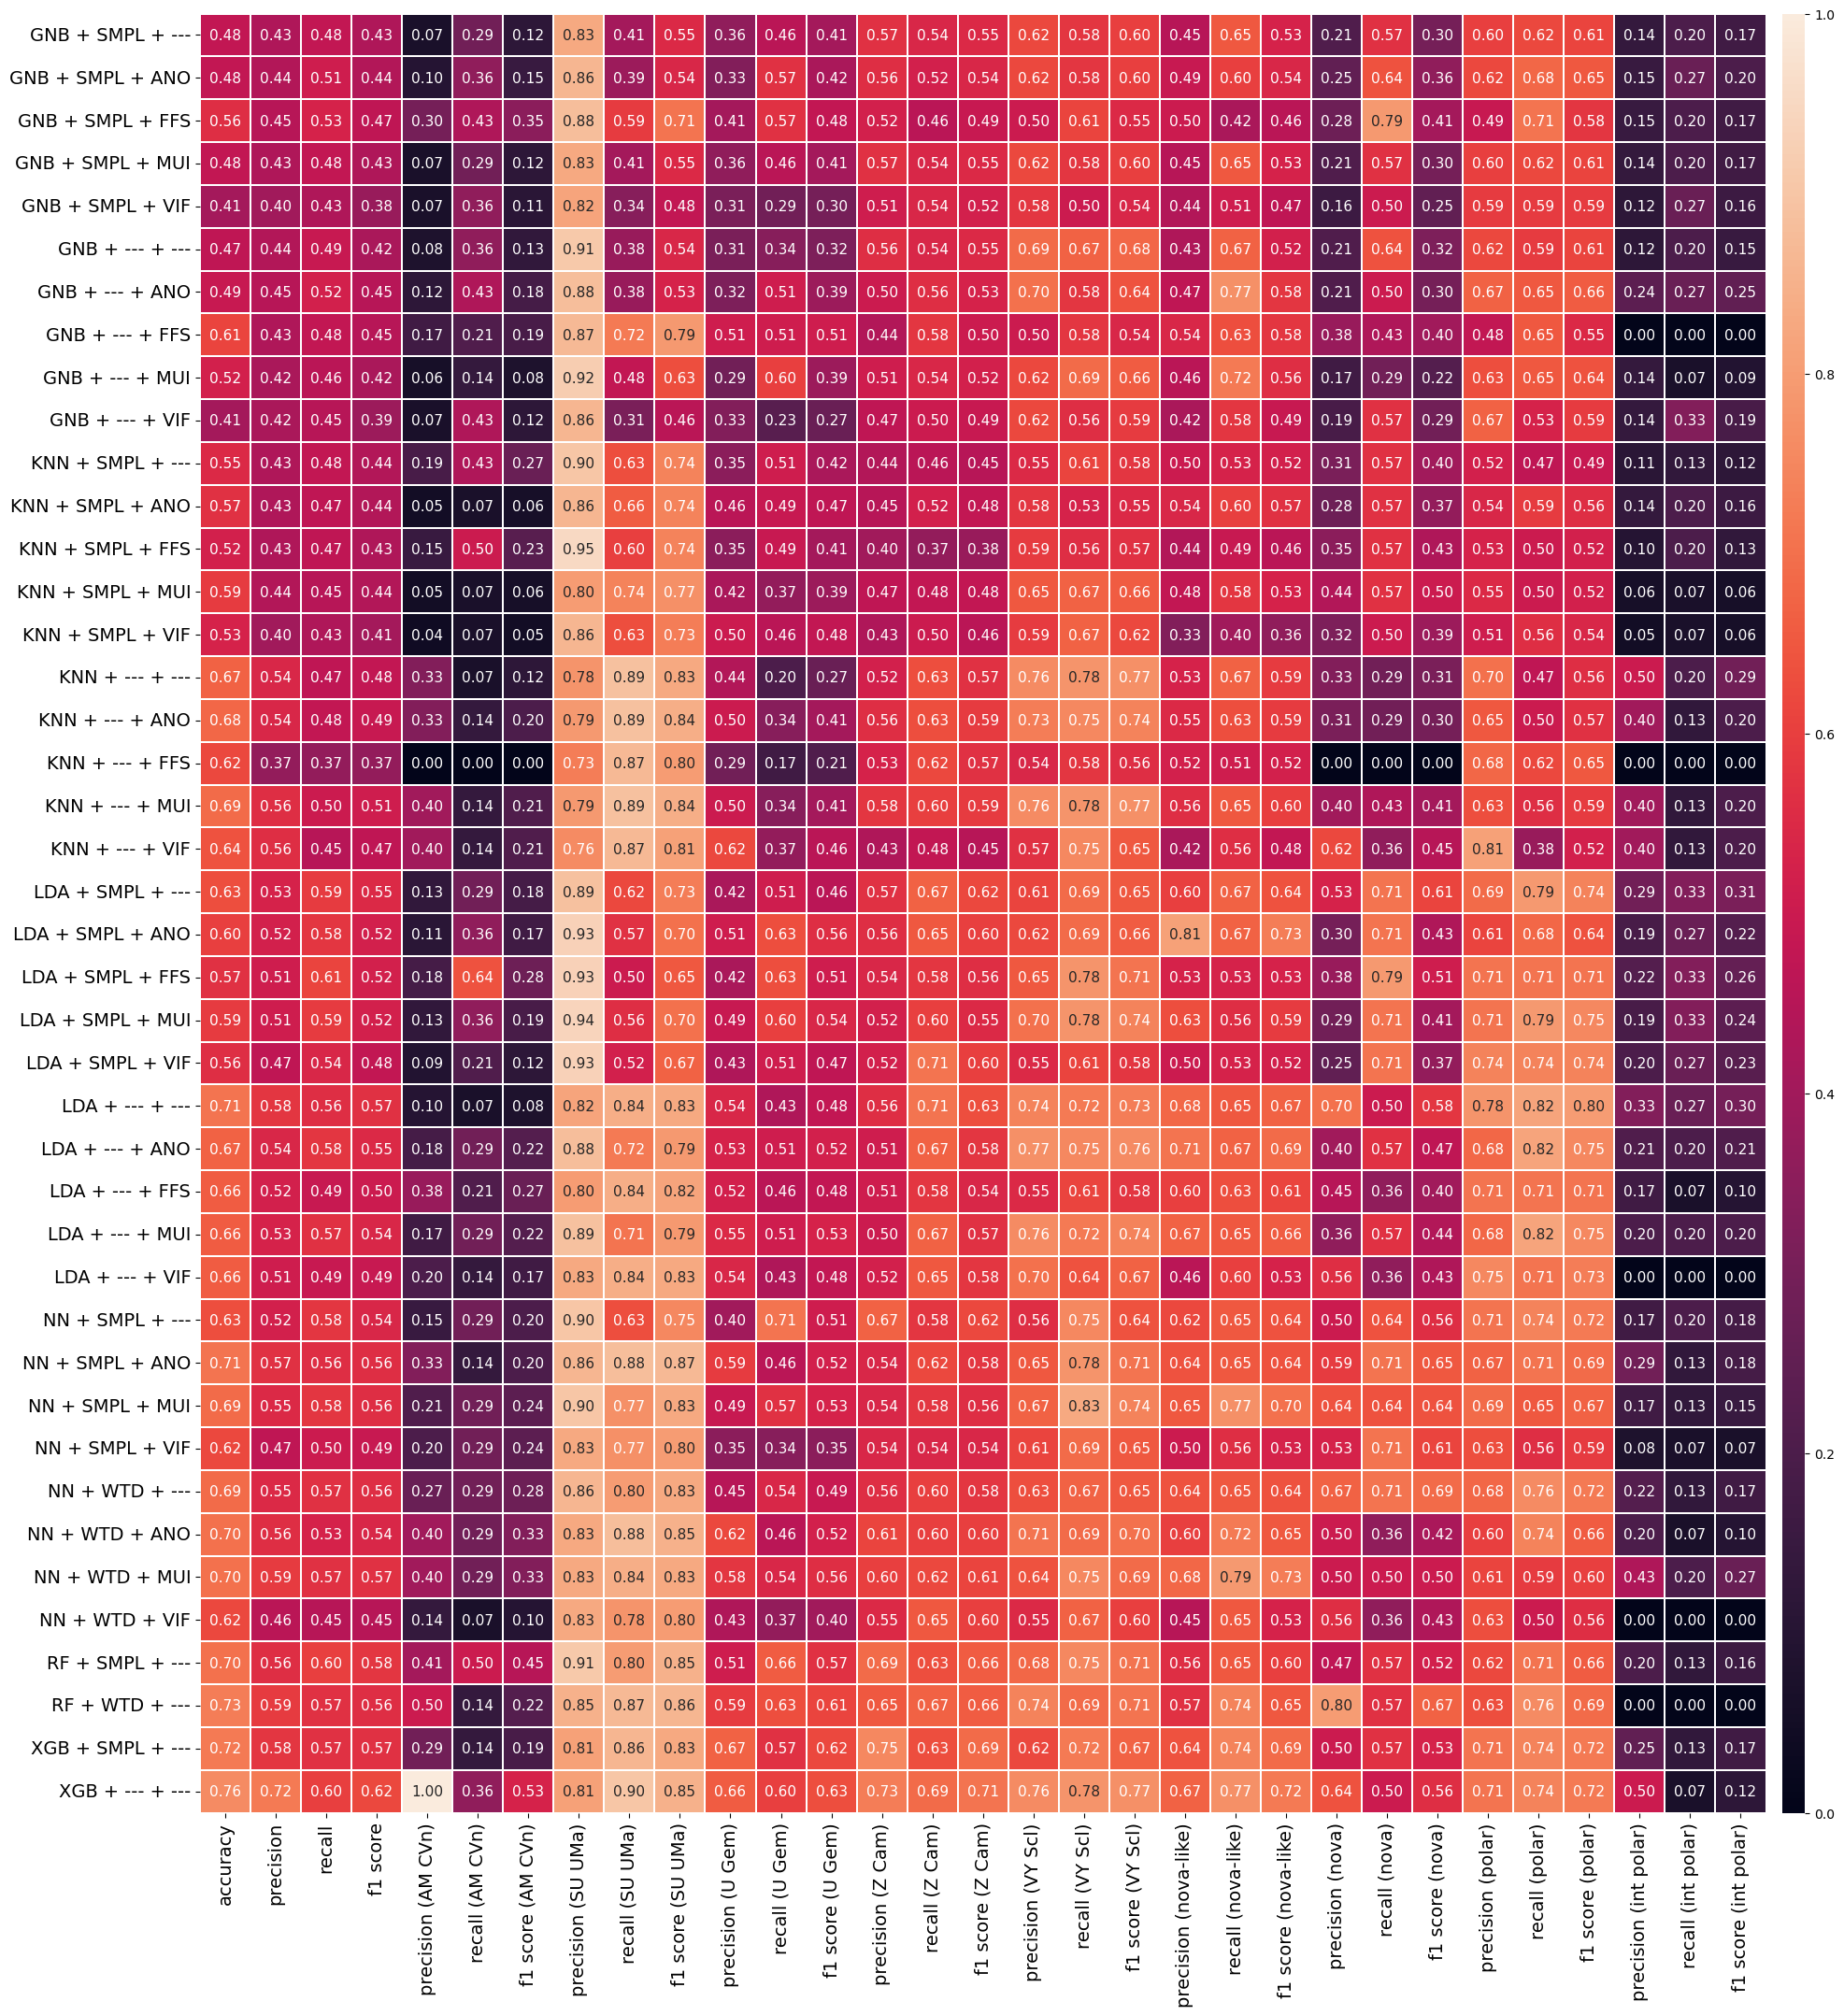

In [23]:
plt.figure(figsize=(23,25))
plt.yticks(ha='right', fontsize=14)
plt.xticks(fontsize=14)

sns.heatmap(results_df_comb, 
            annot=True,
            annot_kws={'size':11},
            fmt='.2f',
            cbar_kws={'aspect': 80, 'fraction': 0.05, 'pad':0.01},
            linewidths=0.005,
            linecolor='white')
plt.savefig(f'../results/results_table.pdf', bbox_inches='tight', format='pdf')

### Compute some statistics

In [24]:
# Compare class balancing methods for each algorithm.

start = 38
stop = 42
print(results_df_comb.iloc[start:stop,0])
print(results_df_comb.iloc[start:stop,0].mean(), results_df_comb.iloc[start:stop,0].std())
print(results_df_comb.iloc[start:stop,0].index)

RF + SMPL + ---     0.70
RF + WTD + ---      0.73
XGB + SMPL + ---    0.72
XGB + --- + ---     0.76
Name: accuracy, dtype: float64
0.7275 0.025000000000000022
Index(['RF + SMPL + ---', 'RF + WTD + ---', 'XGB + SMPL + ---',
       'XGB + --- + ---'],
      dtype='object')


In [25]:
# Compare class balancing methods across all algorithms.
metric = 'f1 score' # 'accuracy', 'f1_score', 'precision', 'recall', 'roc_auc'
sampling = results_df_comb.loc[results_df_comb.index.str.contains('SMPL'),metric]
print(sampling.values)
sampling_mean = sampling.mean()
sampling_std = sampling.std()

weighted = results_df_comb.loc[results_df_comb.index.isin(['GNB + --- + ---', 
                                                                'GNB + --- + ANO', 
                                                                'GNB + --- + FFS',
                                                                'GNB + --- + MUI', 
                                                                'GNB + --- + VIF',
                                                                'KNN + --- + ---', 
                                                                'KNN + --- + ANO', 
                                                                'KNN + --- + FFS',
                                                                'KNN + --- + MUI',
                                                                'KNN + --- + VIF',
                                                                'LDA + --- + ---', 
                                                                'LDA + --- + ANO', 
                                                                'LDA + --- + FFS',
                                                                'LDA + --- + MUI', 
                                                                'LDA + --- + VIF',
                                                                'NN + WTD + ---', 
                                                                'NN + WTD + ANO', 
                                                                'NN + WTD + MUI', 
                                                                'NN + WTD + VIF',
                                                                'RF + WTD + ---',
                                                                'XGB + WTD + ---'
                                                                ]),metric]

weighted_mean = weighted.mean()
weighted_std = weighted.std()

print(sampling_mean, sampling_std)
print(weighted_mean, weighted_std)

from scipy import stats
ttest = stats.ttest_ind(sampling.values, weighted.values)
print(ttest)

[0.43 0.44 0.47 0.43 0.38 0.44 0.44 0.43 0.44 0.41 0.55 0.52 0.52 0.52
 0.48 0.54 0.56 0.56 0.49 0.58 0.57]
0.48571428571428577 0.06021390442177195
0.489 0.061207154724539234
Ttest_indResult(statistic=-0.17325072768465516, pvalue=0.8633504362258783)


In [26]:
# Compare the difference in performance between different classifiers.

metric = 'f1 score (AM CVn)' # 'accuracy' or 'f1-score' or 'precision' or 'recall'

GNBandKNN = results_df_comb.loc[results_df_comb.index.str.contains('GNB|KNN'), metric]
inverseGNBandKNN = results_df_comb.loc[~results_df_comb.index.str.contains('GNB|KNN'), metric]

print(GNBandKNN.mean(), GNBandKNN.std())
print(inverseGNBandKNN.mean(), inverseGNBandKNN.std())

ttest2 = stats.ttest_ind(GNBandKNN.values, inverseGNBandKNN.values, equal_var=False)
print(ttest2)

0.148 0.08338875350145433
0.23681818181818184 0.10480759530984401
Ttest_indResult(statistic=-3.051854666658034, pvalue=0.0040624292294832815)


In [27]:
# Compare the difference in performance due to the feature selection methods
metric = 'f1 score (AM CVn)'
fr = 'FFS'

fr_method = results_df_comb.loc[(results_df_comb.index.str.contains(fr)), metric]
# fr_method2 = results_df_comb.loc[results_df_comb.index.str.contains('FFS'), 'accuracy2']
inverse_fr_method = results_df_comb.loc[(~results_df_comb.index.str.contains(fr)) &
                                        (~results_df_comb.index.str.contains('RF')) &
                                        (~results_df_comb.index.str.contains('XGB')) &
                                        (~results_df_comb.index.str.contains('^NN')) &
                                        (~results_df_comb.index.str.contains('MUI')) &
                                        (~results_df_comb.index.str.contains('ANO')) &
                                        (~results_df_comb.index.str.contains('VIF')),
                                        metric]

print(f'{fr}: ', fr_method.mean(), fr_method.std())
print(f'Inverse {fr}: ', inverse_fr_method.mean(), inverse_fr_method.std())

ttest_fr = stats.ttest_ind(fr_method, inverse_fr_method, equal_var=False)
print('T-test: ', ttest_fr)
inverse_fr_method, fr_method

FFS:  0.22 0.1203328716519306
Inverse FFS:  0.15 0.06693280212272605
T-test:  Ttest_indResult(statistic=1.2452441171884352, pvalue=0.24904404923620818)


(GNB + SMPL + ---    0.12
 GNB + --- + ---     0.13
 KNN + SMPL + ---    0.27
 KNN + --- + ---     0.12
 LDA + SMPL + ---    0.18
 LDA + --- + ---     0.08
 Name: f1 score (AM CVn), dtype: float64,
 GNB + SMPL + FFS    0.35
 GNB + --- + FFS     0.19
 KNN + SMPL + FFS    0.23
 KNN + --- + FFS     0.00
 LDA + SMPL + FFS    0.28
 LDA + --- + FFS     0.27
 Name: f1 score (AM CVn), dtype: float64)

In [28]:
# Get the mean and standard deviation of algorithm selected by way of highest ranking on macro avg f1 score
def cvresultstable():

    classifierNm = {'gnb':'GNB','knn':'KNN','lda':'LDA','xgb':'XGB','rf':'RF'}
    balancing = {'weights':'WTD','sampling':'SMPL'}
    frmethod = {'mi':'MUI', 'mi_':'MUI', 'sfs_':'FFS', 'anova':'ANO', 'anova_':'ANO', 'vif_':'VIF', '':'---'}

    results_dict = {}

    for clf in classifierNm.keys():
        for bal in balancing.keys():
            for fr in frmethod.keys():
                # print(clf, bal, fr)
                try:
                    if fr != '':
                        model_results = pd.read_csv(f'../results/cv_results/cv_results_{clf}_{bal}_{fr}.csv')
                        results_dict[f'{classifierNm[clf]} + {balancing[bal]} + {frmethod[fr]}'] = {
                                                                                                    'mean': model_results.loc[model_results['rank_test_f1_macro']==1,'mean_test_f1_macro'].values[0],
                                                                                                    'std': model_results.loc[model_results['rank_test_f1_macro']==1,'std_test_f1_macro'].values[0]
                                                                                                    }

                    elif fr == '':
                        model_results = pd.read_csv(f'../results/cv_results/cv_results_{clf}_{bal}.csv')
                        results_dict[f'{classifierNm[clf]} + {balancing[bal]} + {frmethod[fr]}'] = {
                                                                                                    'mean': model_results.loc[model_results['rank_test_f1_macro']==1,'mean_test_f1_macro'].values[0],
                                                                                                    'std': model_results.loc[model_results['rank_test_f1_macro']==1,'std_test_f1_macro'].values[0]
                                                                                                    }
                except:
                    continue
                    # print('No model found')
        
    results_df = pd.DataFrame(results_dict).T

    # order the rows alphabetically
    results_df = results_df.reindex(sorted(results_df.index))

    return results_df




cv_results = cvresultstable()


In [29]:
cv_results

,mean,std
GNB + SMPL + ---,0.418191,0.045343
GNB + SMPL + ANO,0.434877,0.050701
GNB + SMPL + FFS,0.477196,0.087366
GNB + SMPL + MUI,0.418191,0.045343
GNB + SMPL + VIF,0.364851,0.050604
GNB + WTD + ---,0.385398,0.050901
GNB + WTD + ANO,0.421606,0.044111
GNB + WTD + FFS,0.521079,0.053446
GNB + WTD + MUI,0.420430,0.055287
GNB + WTD + VIF,0.329329,0.047600


In [30]:
cv_results = pd.read_csv(f'../results/cv_results/cv_results_xgb_weights.csv')
# cv_results.sort_values(by='rank_test_balanced_accuracy', ascending=True)
cv_results.loc[cv_results['rank_test_f1_macro']==1,'mean_test_f1_macro'].values[0]

0.5941041873978525

### McNemars test

In [31]:
a = pickle.load(open('../results/best_params/best_params_NN_weights_mi_.pkl', 'rb'))

from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif, f_classif


statistic=10.000, p-value=1.000
Same proportions of errors (fail to reject H0)
dwarf_nova_SU_UMa    630
dwarf_nova_Z_Cam     174
nova_like            144
nova_like_VY_Scl     120
dwarf_nova_U_Gem     116
polar                114
int_polar             49
AMCVn                 46
nova                  46
Name: labels_2, dtype: int64
['XGB + --- + ---', 'RF + SMPL + ---', 'XGB + SMPL + ---', 'NN + WTD + MUI', 'LDA + --- + ---', 'RF + WTD + ---', 'NN + WTD + ---', 'NN + SMPL + MUI', 'NN + SMPL + ANO', 'LDA + SMPL + ---']
[09:57:39] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about dif

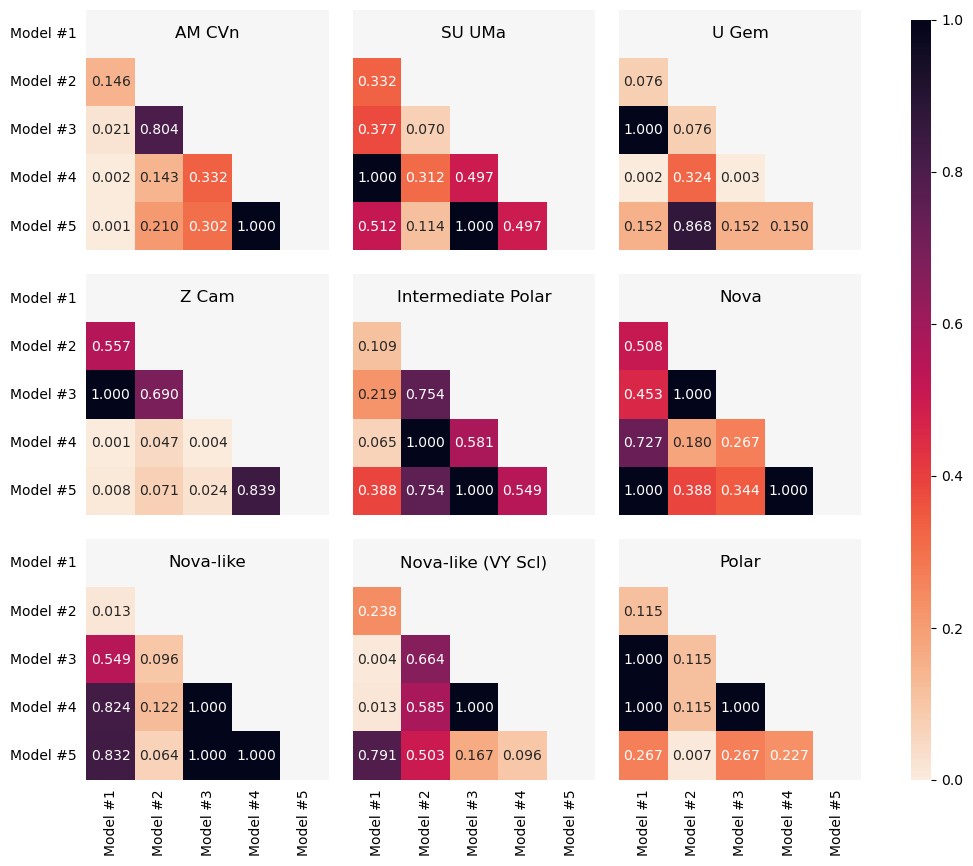

In [33]:
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from raw_processing import ColumnTransformerPandas
from sklearn.metrics import confusion_matrix
import pickle
import matplotlib.cm as colormap
from tensorflow.keras.models import load_model
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
from sklearn.impute import KNNImputer

# McNemar test example
# define contingency table
table = [[10, 10],
         [10, 10]]
# calculate mcnemar test
result = mcnemar(table, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
    print('Same proportions of errors (fail to reject H0)')
else:
    print('Different proportions of errors (reject H0)')

##########################################################################################

def contingency_table(model_1_preds, model_2_preds, y_test, class_name):

    # A list of whether a given example is assigned to the class or not, for each model.
    model_1_preds_class = model_1_preds == class_name
    model_2_preds_class = model_2_preds == class_name
    # A list of whether a given example actually belongs to the class or not, based upon the true labels.
    y_test_class = y_test == class_name
    # Create a pandas dataframe that combines all three of the above lists.
    table = pd.DataFrame({'model_1_preds_class': model_1_preds_class, 'model_2_preds_class': model_2_preds_class, 'y_test_class': y_test_class})
    model1_correct_model2_correct = table[((table['model_1_preds_class'] == True) & (table['model_2_preds_class'] == True) & (table['y_test_class'] == True)) |
                                          ((table['model_1_preds_class'] == False) & (table['model_2_preds_class'] == False) & (table['y_test_class'] == False))].shape[0]
    
    model1_incorrect_model2_incorrect = table[((table['model_1_preds_class'] == True) & (table['model_2_preds_class'] == True) & (table['y_test_class'] == False)) |
                                          ((table['model_1_preds_class'] == False) & (table['model_2_preds_class'] == False) & (table['y_test_class'] == True))].shape[0]
    
    model1_correct_model2_incorrect = table[((table['model_1_preds_class'] == True) & (table['model_2_preds_class'] == False) & (table['y_test_class'] == True)) |
                                            ((table['model_1_preds_class'] == False) & (table['model_2_preds_class'] == True) & (table['y_test_class'] == False))].shape[0]
    
    model1_incorrect_model2_correct = table[((table['model_1_preds_class'] == True) & (table['model_2_preds_class'] == False) & (table['y_test_class'] == False)) |
                                            ((table['model_1_preds_class'] == False) & (table['model_2_preds_class'] == True) & (table['y_test_class'] == True))].shape[0]
    
    contingency_table = np.array([[0, 0],
                                  [0, 0]])
    contingency_table[0][0] = model1_correct_model2_correct
    contingency_table[0][1] = model1_correct_model2_incorrect
    contingency_table[1][0] = model1_incorrect_model2_correct
    contingency_table[1][1] = model1_incorrect_model2_incorrect
    
    return contingency_table

def compare_classifiers (model_dict, y_test, class_name):
    # Get the p_values of the McNemar test for each pair of models.
    # I would like to produce a dataframe of p_values, where each row is a model and each column is a model.
    # The cell is the p_value of the McNemar test for the pair of models.
    p_values_df = pd.DataFrame()
    p_values_df.index = model_dict.keys()
    for key in model_dict.keys():
        p_values_df[key] = np.nan

    for model_1_name in model_dict.keys():
        for model_2_name in model_dict.keys():
            if model_1_name != model_2_name:
                ct = contingency_table(model_dict[model_1_name], model_dict[model_2_name], y_test, class_name)
                result = mcnemar(ct, exact=True)
                p_values_df.loc[model_1_name, model_2_name] = result.pvalue

    # show as a seaborn heatmap.
    # plt.figure(figsize=(10,8))
    # plt.title(f'p-values for McNemar test for class {class_name}')
    # sns.heatmap(p_values_df, annot=True)

    return p_values_df

# Okay, lets load the data and obtain the training and test sets.
label_scheme = 'labels_2'
dataset = pd.read_csv(f'../processed_data/dataset_allfeatures_inc_labels.csv', low_memory=False)
dataset = dataset[dataset[label_scheme].notna()].reset_index(drop=True)
print(dataset[label_scheme].value_counts())
X = dataset.iloc[:,14:]
X_cols = X.columns.tolist()
y_names = dataset[label_scheme]
enc = LabelEncoder().fit(y_names)
y = enc.transform(y_names)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

X_train_dummy = X_train.fillna(0)

# For feature reduction NN
impute_KNN = ColumnTransformerPandas([
    ('imputer', KNNImputer(n_neighbors=5, weights='distance'), X_cols)],
    remainder='passthrough')

normalise = ColumnTransformerPandas([
    ('normalise', StandardScaler(), X_cols)], 
    remainder='passthrough')

pipe = Pipeline([
    ('preimpnorm', normalise),
    ('impute', impute_KNN),
])

X_trainNN, X_valNN, y_trainNN, y_valNN = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=1)
X_trainNN = pipe.fit_transform(X_trainNN, y_trainNN)
X_testNN = pipe.transform(X_test)


top10models = results_df_comb.sort_values(by='f1 score', ascending=False).head(10).index.tolist()
print(top10models)
top10models = ['XGB + --- + ---', 
               'RF + SMPL + ---', 
               'XGB + SMPL + ---', 
               'NN + WTD + MUI', 
               'LDA + --- + ---',
               'RF + WTD + ---',
               'NN + WTD + ---',
               'NN + SMPL + MUI',
               'NN + SMPL + ANO',
               'LDA + SMPL + ---']


# Load the models and get the predictions
xgb_weights = pickle.load(open(f'../results/model/model_xgb_weights_None_.pkl', 'rb'))
rf_sampling = pickle.load(open(f'../results/model/model_rf_sampling.pkl', 'rb'))
xgb_sampling = pickle.load(open(f'../results/model/model_xgb_sampling.pkl', 'rb'))
nn_weights_mui = load_model(f'../results/model/model_NN_weights.h5')
lda_weights = pickle.load(open(f'../results/model/model_lda_weights.pkl', 'rb'))
# rf_weights = pickle.load(open(f'../results/model/model_rf_weights.pkl', 'rb'))
# nn_weights = load_model(f'../results/model/model_NN_weights.h5')
# nn_sampling_mui = load_model(f'../results/model/model_NN_sampling_mi_.h5')
# nn_sampling_anova = load_model(f'../results/model/model_NN_sampling_anova_.h5')
# lda_sampling = pickle.load(open(f'../results/model/model_lda_sampling.pkl', 'rb'))


xgb_weights_preds = xgb_weights.predict(X_test)
rf_sampling_preds = rf_sampling.predict(X_test)
xgb_sampling_preds = xgb_sampling.predict(X_test)
nn_weights_mui_preds = nn_weights_mui.predict(X_testNN)
nn_weights_mui_preds = np.argmax(nn_weights_mui_preds, axis=1)
lda_weights_preds = lda_weights.predict(X_test)

# print(confusion_matrix(y_test, xgb_weights_preds))
# print(confusion_matrix(y_test, rf_sampling_preds))
# print(confusion_matrix(y_test, xgb_sampling_preds))
# print(confusion_matrix(y_test, nn_weights_mui_preds))
# print(confusion_matrix(y_test, lda_weights_preds))


# Place the predictions into a dictionary
model_dict = {'Model #1': xgb_weights_preds,
              'Model #2': rf_sampling_preds,
              'Model #3': xgb_sampling_preds,
              'Model #4': nn_weights_mui_preds,
              'Model #5': lda_weights_preds
              }

              
              

# Compare the models for the class 'AM CVn'

# Create a figure of subplots where each subplot a heatmap of the dataframe output from the compare_classifiers function for each class.
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.1, wspace=0.1)

class_names = enc.inverse_transform([0,1,2,3,4,5,6,7,8])
print(class_names)
class_names = ['AM CVn', 'SU UMa', 'U Gem', 'Z Cam',
               'Intermediate Polar', 'Nova', 'Nova-like', 
               'Nova-like (VY Scl)', 'Polar']
for i in range(3):
    for j in range(3):
        ax[i,j].set_title(f'{class_names[i*3+j]}', fontsize=12, x=0.5, y=0.85)
        ax[i,j].tick_params(left=False, bottom=False)
        # Getting the Upper Triangle of the co-relation matrix
        p_values = compare_classifiers(model_dict, y_test, i*3+j)
        mask = np.triu(p_values)
        # mask = None
        cmap = colormap.get_cmap('rocket_r')
        cmap.set_bad("#F6F6F6")
        ax[i,j] = sns.heatmap(p_values, cmap=cmap,annot=True, ax=ax[i,j], mask=mask, vmin=0, vmax=1, fmt='.3f', cbar=None)



cb_ax = fig.add_axes([0.95, 0.11, 0.02, 0.76])
cbar = fig.colorbar(ax[1,2].collections[0], cax=cb_ax)
cbar.outline.set_visible(False)

fig.savefig('../results/McNemars/McNemars.pdf', format='pdf', bbox_inches='tight') 



In [296]:
# top 10 models based on macro avg f1 score
results_df_comb.sort_values(by='f1 score', ascending=False).head(10).index.tolist()

['XGB + --- + ---',
 'RF + SMPL + ---',
 'XGB + SMPL + ---',
 'NN + WTD + MUI',
 'LDA + --- + ---',
 'RF + WTD + ---',
 'NN + WTD + ---',
 'NN + SMPL + MUI',
 'NN + SMPL + ANO',
 'LDA + SMPL + ---']